In [17]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import random
import statistics

In [18]:
from collections import namedtuple, deque
from itertools import count
from PIL import Image

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [77]:
class Rewarder(nn.Module):
    def __init__(self, num_hidden_units, input_dim):
        super(Rewarder,self).__init__()
        
        self.rewarder_net = nn.Sequential(
            nn.Linear(input_dim, num_hidden_units),
            nn.ReLU(),
            nn.Linear(num_hidden_units,1)
        ) 
        
    def forward(self, input_obs):
        return int(self.rewarder_net(input_obs))
    

class Actor(nn.Module):
    def __init__(self, num_actions, num_hidden_units, input_dim):
        super(Actor,self).__init__()
        
        self.actor_net = nn.Sequential(
            nn.Linear(input_dim, num_hidden_units),
            nn.ReLU(),
            nn.Linear(num_hidden_units,num_actions),
            nn.Softmax(dim=0)
        ) 
        
        
    def forward(self, input_obs):
        return self.actor_net(input_obs)

In [81]:
class GridWorld():
    def __init__(self):
        self.state = self.init_state()
        self.step_count = 0
        
    def init_state(self):
        xs = random.sample(range(0,7),5)
        ys = random.sample(range(0,7),5)
        piece_pos = [xs[0], ys[0]]
        players_pos = [xs[4], ys[4]]
        positions = list(np.array([players_pos, piece_pos]).flatten())
        return positions
        
    def reset(self):
        self.state = self.init_state()
        self.step_count = 0
        
    def step(self, action):
        self.step_count += 1
        
        if action == 0: #up
            self.state[1] += 1
            
        if action == 1: #right
            self.state[0] += 1
            
        if action == 2: #down
            self.state[1] -= 1
            
        if action == 3: #left
            self.state[0] -= 1
            
        if (self.step_count >= 25) : # loss max step
            self.reset()
            # reward function
            # with torch.no_grad():
            #    reward = int(rewarder(torch.unsqueeze(self.state, 0), training=False)[0])
            reward = int(rewarder(self.state))
            playing = False
            
            return reward, playing
        
        if (self.state[0] == self.state[2]) and (self.state[1] == self.state[3]): # win the game
            playing = False
            reward = 100
            # reward learning model
            # with torch.no_grad():
            #    reward = int(rewarder(torch.unsqueeze(self.state, 0), training=False)[0])
            self.reset()
            return reward, playing
        
        playing = True

        # reward function
        #with torch.no_grad():
        #    reward = int(rewarder(torch.unsqueeze(self.state, 0), training=False)[0])
        reward = int(rewarder(torch.Tensor(self.state)))
        
        return reward, playing

In [89]:
rewarder = Rewarder(num_hidden_units = 64, input_dim = 4)
agent = Actor(num_actions = 4, num_hidden_units = 64, input_dim = 4)
env = GridWorld()
env.state

[6, 2, 4, 1]

In [90]:
action_proba = agent(torch.Tensor(env.state))
action_index = torch.argmax(action_proba)
reward, playing = env.step(action_index)
reward

0

In [91]:
env.state

[6, 1, 4, 1]

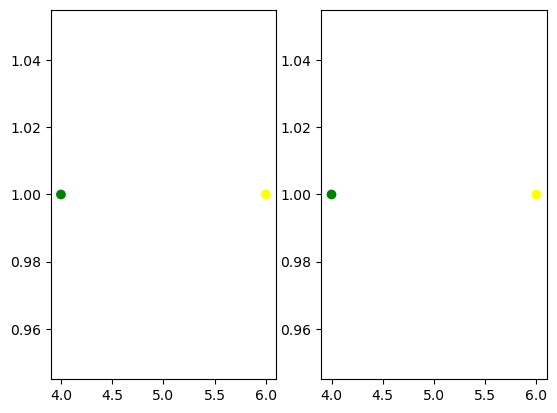

In [98]:
fig, ax = plt.subplots(1,2)
colors = ['yellow','green']

color_indices = [0, 1]
colormap = matplotlib.colors.ListedColormap(colors)

ax[0].scatter([env.state[0], env.state[2]] , [env.state[1],env.state[3]], c=color_indices, cmap=colormap)

ax[1].scatter([env.state[0], env.state[2]] , [env.state[1],env.state[3]], c=color_indices, cmap=colormap)

In [32]:
def compare (transition_ids, states, actions):
    states = 0
    d1xs = [states[transition_ids[0]][0][0], states[transition_ids[0]][0][2]]
    d1ys = [states[transition_ids[0]][0][1], states[transition_ids[0]][0][3]]
    d2xs = [states[transition_ids[1]][0][0], states[transition_ids[0]][0][2]]
    d2ys = [states[transition_ids[1]][0][1], states[transition_ids[0]][0][3]]

    fig, ax = plt.subplots(2,2)
    colors = ['yellow','green']
    color_indices = [0, 1, ]
    colormap = matplotlib.colors.ListedColormap(colors)
    ax[0,0].scatter(d1xs, d1ys, c=color_indices, cmap=colormap)
    ax[0,0].set_title(str(decode_action(actions[transition_ids[0]].numpy())))
    ax[0,1].scatter(d2xs, d2ys, c=color_indices, cmap=colormap)
    ax[0,1].set_title(str(decode_action(actions[transition_ids[1]].numpy())))
    plt.show()

In [33]:
def decode_action(action):
    if action == 0:
        return 'up'
    if action == 1:
        return 'right'
    if action == 2:
        return 'down'
    if action == 3:
        return 'left'        

In [ ]:
# here states ref to a lot of differents states
def preference_update( states, actions, rewarder):
    transition_ids = random.sample(range(0, len(states) -2), 2)
    compare(transition_ids, states, actions)
    pref = input (' select preference a:left, d:right, s:same ')
    if pref == 'a':
        dist = [ 1, 0 ]
    if pref == 'd':
        dist = [ 0, 1 ]
    if pref == 's':
        dist = [ 1, 1 ]
        
    # stuff gradient
    reward_1 = rewarder( state[transition_ids[0] + 1])
    reward_2 = rewarder( state[transition_ids[1] + 1])
    p1 = torch.exp(reward_1) / (torch.exp(reward_1) + torch.exp(reward_2))
    p2 = torch.exp(reward_2) / (torch.exp(reward_1) + torch.exp(reward_2))
    loss = - ( p1*dist[0] + p2*dist[1] )
    #grads = torch gradient (loss, rewarder variable)
    # optimizer ( grads, rewarder)
    
    

In [ ]:
# train the reward funtion on a state and action
# return multiple states
def step_episode(env, model):
    env.reset()
    action_prob_list = []
    rewards = []
    states = []
    actions = []
    playing = True
    
    while playing == True
        observation = expand dim (env.state)
        
        # run model
        action_logits = agent(obs)
        
        #categorical probabilistic action idx selection
        selected_action_idx = random categorical (action_logits, 1 )[ 0, 0]
        
        states.append(observation)
        action.append(selected_action_idx)
        
        reward, playing = env.step(selected_action_idx)
        
        #normalize proba
        action_probs = softmax function ( action_logits)
        probability_of_taking_selected_action = action_probs[0, selected_action_idx]
        action_probs_list.append(probability_of_taking_selected_action)
        rewards.append(reward)
        
    return action_probs_list, rewards, states, actions

In [ ]:
agent = Actor (num_action = 4, num_hidden_units = 100)

rewarder = Rewarder(num_hidden_unites = 100)

env = GridWorld()
optimizer = torch.optim.Adam(policy_net.parameters(), lr=1e-4)

# criterion = nn.CrossEntropyLoss()
# loss = self.criterion(output, train_target.narrow(0, b, mini_batch_size))
#                acc_loss = acc_loss + loss.item()
#                self.autoenc.zero_grad()
#                loss.backward()
#                self.optimizer.step()

In [ ]:
def calc_g(reward_trajectory, gamma):
    ez_discount = np.array([ gamma**n for n in range(len(reward_trajectory))])
    gs = []
    reward_trajectory = np.array(reward_trajectory)
    for ts in range(len(reward_trajectory)):
        to_end_rewards = reward_trajectory[ts:]
        eq_len_discount = ez_discount[:len(reward_trajectory[ts:])]
        total_value = np.multiply(to_end_rewards, eq_len_discount)
        g = sum(total_value)
        gs.append(g)
    return gs   

In [ ]:
for episode in range(5000):
    action_probs, rewards, states ,actions = step_episode (env, agent)
    loss = actor_loss (action_probs ,rewards)